# Data Exploration

This notebook explores the Reddit data collected for our cross-lingual stance detection project on climate change discussions, including preliminary stance analysis.

In [22]:
# Configuration
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import glob
import datetime
from tqdm import tqdm

# Set plotting style and configurations
sns.set_theme(style="whitegrid")  # Use seaborn's default style
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Constants
RANDOM_STATE = 42
FIGURE_SIZE = (12, 6)

In [4]:
# Load the data
latest_file = max(glob.glob('../data/raw/*.csv'), key=os.path.getctime)
data = pd.read_csv(latest_file)
print(f"Loaded {len(data)} posts")
data.head()

Loaded 8081 posts


,id,title,body,score,num_comments,created_utc,language,subreddit,collected_at,title_length,body_length,language_verified,verification_status,total_length
0,wu9zny,The r/climatechange Verified User Flair Program,r/climatechange is a community centered around...,41,20,2022-08-21 16:53:23,en,climatechange,2024-11-06 23:55:16.346632,47,3164,True,verified,3212
1,1glbafl,I’m incredibly sad for our environment today.,Trump has all but signed a death warrant for o...,717,196,2024-11-06 17:38:25,en,climatechange,2024-11-06 23:55:16.732102,46,527,True,verified,573
2,1glc2te,I’m sad. We really do live in a post-truth wor...,NaN,315,51,2024-11-06 18:13:11,en,climatechange,2024-11-06 23:55:16.735062,109,0,True,verified,108
3,1gl6msi,The US is about to make a sharp turn on climat...,NaN,160,27,2024-11-06 14:21:42,en,climatechange,2024-11-06 23:55:16.737426,54,0,True,verified,54
4,1gl7j9u,The US just abdicated from any role in climate...,Climate engineering is now the only chance hum...,123,22,2024-11-06 14:59:18,en,climatechange,2024-11-06 23:55:16.739338,151,70,True,verified,221


## 1. Basic Statistics

In [5]:
print(data.describe())
print("\nData distribution by language:")
print(data['language'].value_counts())

          score  num_comments  title_length  body_length  total_length
count  8081.000      8081.000      8081.000     8081.000      8081.000
mean     45.543        14.592        88.893      189.708       278.744
std     208.220        51.032        59.066      660.686       657.652
min       0.000         0.000         1.000        0.000         1.000
25%       2.000         0.000        53.000        0.000        65.000
50%      10.000         2.000        74.000        0.000        95.000
75%      37.000        11.000       103.000        0.000       229.000
max   10522.000      2135.000       300.000    17286.000     17330.000

Data distribution by language:
language
en    3972
de    1993
it     998
fr     988
es     130
Name: count, dtype: int64


## 2. Time Series Analysis

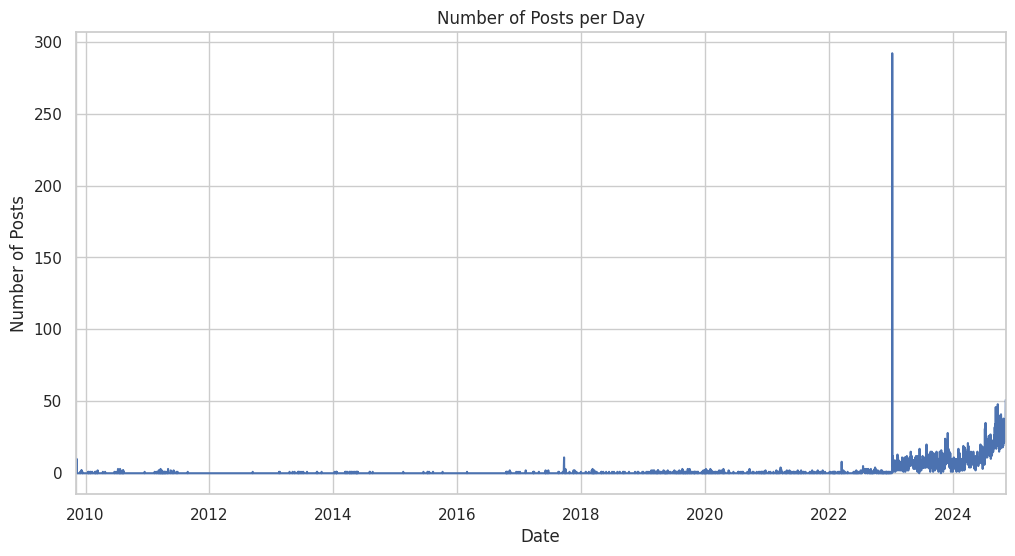

In [6]:
data['created_utc'] = pd.to_datetime(data['created_utc'])
data.set_index('created_utc', inplace=True)
daily_posts = data.resample('D').size()

plt.figure(figsize=FIGURE_SIZE)
daily_posts.plot()
plt.title('Number of Posts per Day')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.show()

## 3. Language-specific Analysis

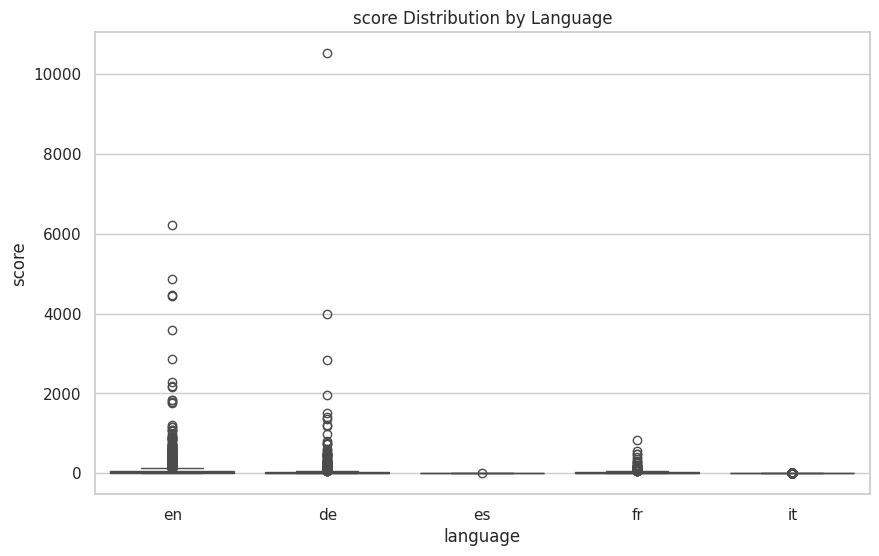

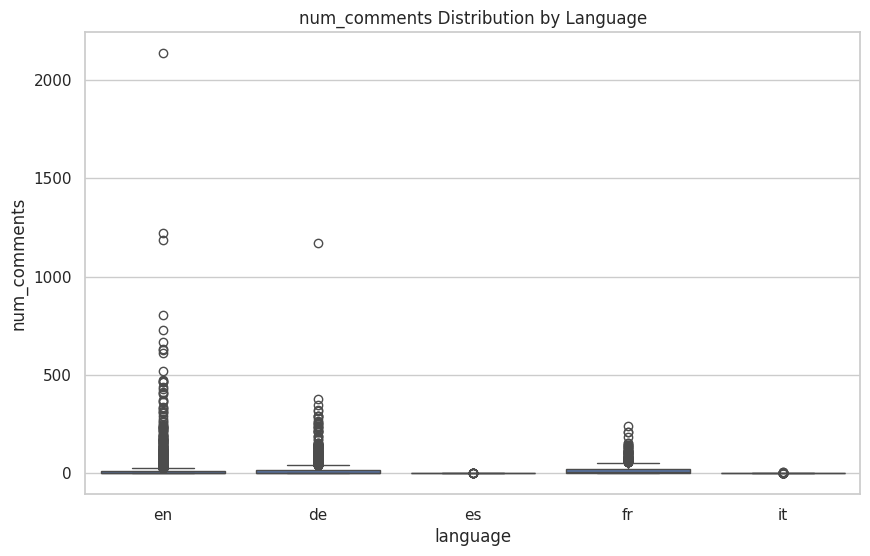

In [7]:
def plot_language_stats(data, column):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='language', y=column, data=data)
    plt.title(f'{column} Distribution by Language')
    plt.show()

plot_language_stats(data, 'score')
plot_language_stats(data, 'num_comments')

## 4. Content Analysis

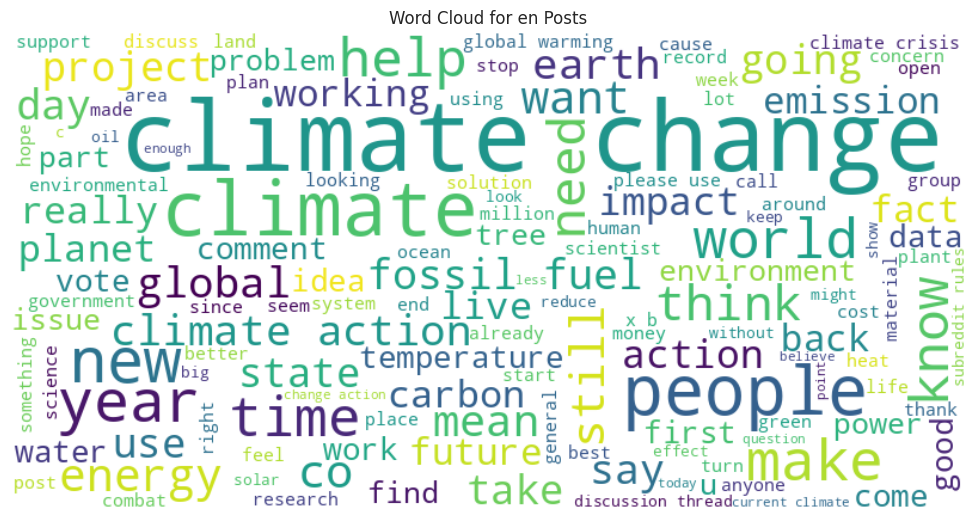

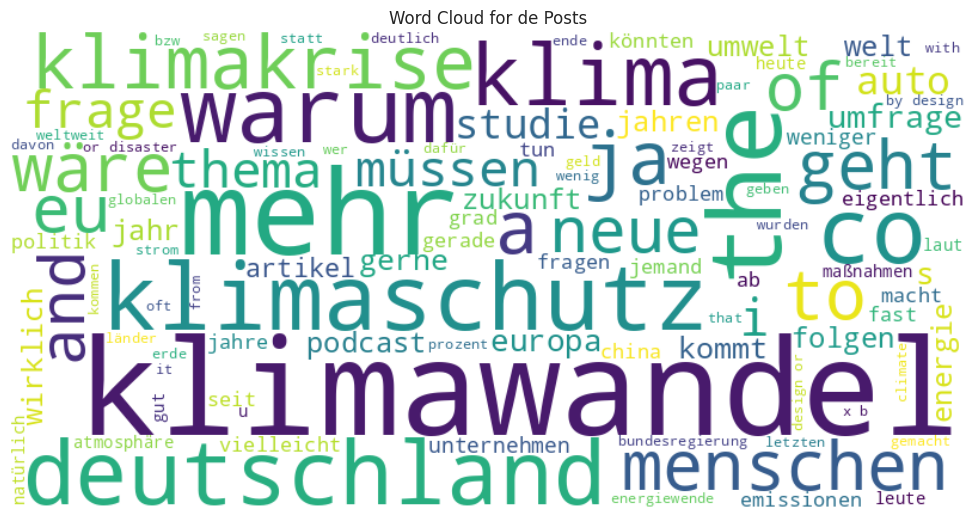

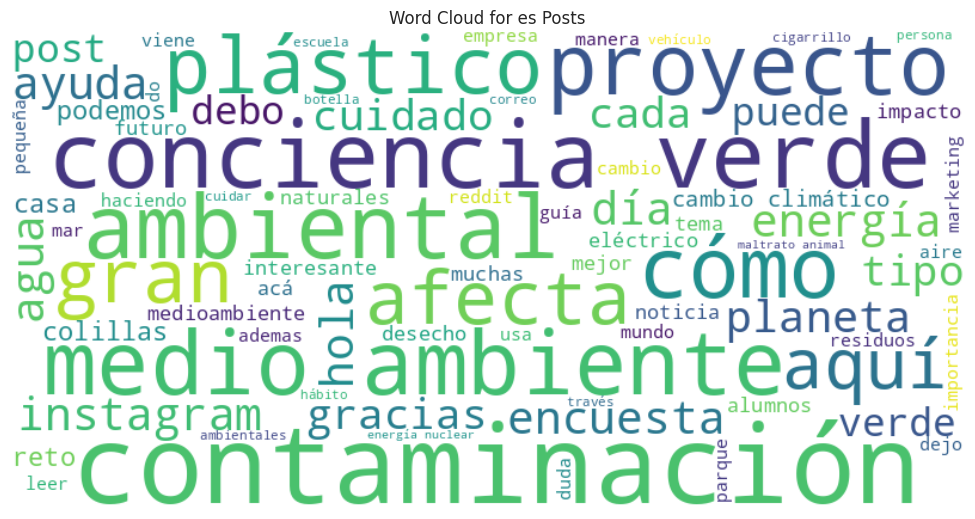

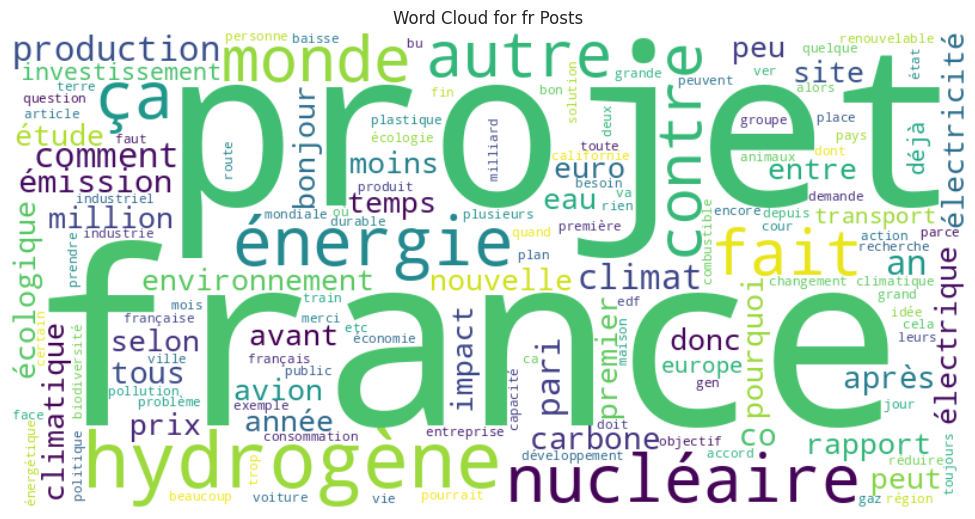

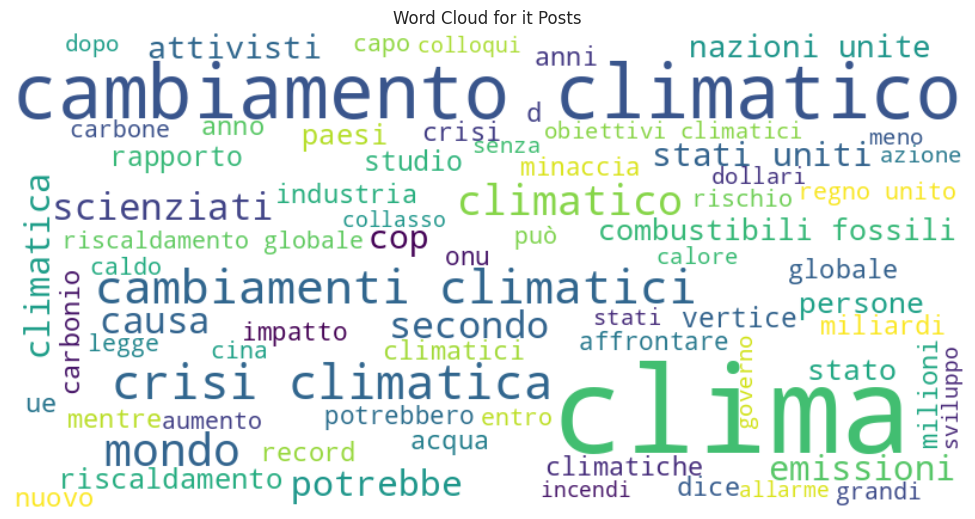

In [8]:
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import re

# Download NLTK stop words data
nltk.download('stopwords', quiet=True)

def clean_text_func(text, language):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove special characters and digits
    text = re.sub(r'\W|\d', ' ', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def get_custom_stop_words(lang):
    custom_stop_words = {
        'english': {'like', 'just', 'get', 'go', 'would', 'could', 'should', 'us', 'one', 'also', 'may', 'well', 'even', 'much', 'many', 'see', 'way'},
        'german': {'mal', 'schon', 'einfach', 'ganz', 'viele', 'viel', 'immer', 'beim', 'gibt', 'sehr', 'kann', 'werden', 'wurde', 'dabei'},
        'spanish': {'si', 'como', 'que', 'esto', 'esta', 'hay', 'ser', 'estar', 'hacer', 'poder', 'más', 'muy', 'todo', 'también'},
        'french': {'cette', 'tout', 'comme', 'plus', 'être', 'faire', 'avoir', 'pouvoir', 'leur', 'même', 'aussi', 'bien', 'très', 'sans', 'a', 'ici', 'si'},
        'italian': {'che', 'come', 'anche', 'più', 'essere', 'fare', 'potere', 'dovere', 'molto', 'tutto', 'ancora', 'bene', 'proprio', 'solo'}
    }
    return custom_stop_words.get(lang, set())

def generate_wordcloud(text, title, language):
    # Get stop words for the specified language
    stop_words = set(stopwords.words(language))
    
    # Add custom stop words
    custom_stop_words = get_custom_stop_words(language)
    stop_words.update(custom_stop_words)
    
    # Create and generate a word cloud image
    wordcloud = WordCloud(width=800, height=400, background_color='white', 
                         stopwords=stop_words, min_font_size=10).generate(text)
    
    # Display the generated image
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.tight_layout(pad=0)
    plt.show()

# Map language codes to NLTK language names
language_map = {
    'en': 'english',
    'de': 'german',
    'es': 'spanish',
    'fr': 'french',
    'it': 'italian'
}

for lang in data['language'].unique():
    lang_data = data[data['language'] == lang]
    
    # Combine title and body, handle NaN values
    text = lang_data['title'].fillna('') + ' ' + lang_data['body'].fillna('')
    
    # Clean the text
    cleaned_text = ' '.join([clean_text_func(t, language_map.get(lang, 'english')) for t in text])
    
    # Generate word cloud
    generate_wordcloud(cleaned_text, f'Word Cloud for {lang} Posts', language_map.get(lang, 'english'))

## 5. Preliminary Stance Analysis

In [38]:
# Global dictionary for all languages
STANCE_DICT = {
    'en': {
        'positive': ['real', 'serious', 'urgent', 'important', 'necessary', 'crisis', 
                    'emergency', 'critical', 'significant', 'proven', 'evidence', 
                    'fact', 'scientific', 'agree', 'support', 'threat', 'danger', 
                    'catastrophic', 'devastating', 'crucial', 'essential'],
        'negative': ['hoax', 'fake', 'exaggerated', 'myth', 'scam', 'alarmist',
                    'alarmism', 'conspiracy', 'overblown', 'propaganda', 'lie',
                    'false', 'misleading', 'hysteria', 'hype', 'overreaction',
                    'agenda', 'political', 'fraud', 'deceptive'],
        'negators': ['not', 'never', 'no', "isn't", "aren't", "doesn't", "don't", 
                    'cannot', "can't", 'neither', 'nor', 'nothing', 'none',
                    'nowhere', 'nobody', 'rather', 'instead'],
        'diminishers': ['barely', 'hardly', 'scarcely', 'seldom', 'rarely', 
                       'slightly', 'somewhat', 'little', 'few', 'less', 'merely',
                       'just', 'only', 'limited']
    },
    'de': {
        'positive': ['real', 'wirklich', 'ernst', 'dringend', 'wichtig', 'notwendig',
                    'krise', 'kritisch', 'wissenschaftlich', 'beweis', 'gefahr', 
                    'bedrohung', 'katastrophal', 'entscheidend', 'wesentlich', 'tatsache'],
        'negative': ['schwindel', 'falsch', 'übertrieben', 'mythos', 'betrug',
                    'propaganda', 'lüge', 'hysterie', 'irreführend', 'agenda',
                    'alarm', 'panik', 'täuschung', 'politik'],
        'negators': ['nicht', 'keine', 'kein', 'niemals', 'nie', 'nein', 'weder',
                    'noch', 'nichts', 'niemand', 'nirgends'],
        'diminishers': ['kaum', 'selten', 'wenig', 'gering', 'schwach', 'begrenzt',
                       'nur', 'bloß', 'lediglich']
    },
    'fr': {
        'positive': ['réel', 'sérieux', 'urgent', 'important', 'nécessaire', 'crise',
                    'critique', 'scientifique', 'preuve', 'danger', 'menace', 
                    'catastrophique', 'crucial', 'essentiel'],
        'negative': ['canular', 'faux', 'exagéré', 'mythe', 'arnaque', 'propagande',
                    'mensonge', 'hystérie', 'trompeur', 'agenda', 'politique',
                    'tromperie'],
        'negators': ['ne', 'pas', 'non', 'jamais', "n'est", "n'est pas", 'aucun',
                    'ni', 'personne', 'rien', 'nulle', "n'"],
        'diminishers': ['à peine', 'rarement', 'peu', 'guère', 'légèrement',
                       'simplement', 'seulement', 'uniquement']
    },
    'es': {
        'positive': ['real', 'serio', 'urgente', 'importante', 'necesario', 'crisis',
                    'crítico', 'científico', 'evidencia', 'peligro', 'amenaza', 
                    'catastrófico', 'crucial', 'esencial'],
        'negative': ['engaño', 'falso', 'exagerado', 'mito', 'estafa', 'propaganda',
                    'mentira', 'histeria', 'engañoso', 'agenda', 'político',
                    'fraude'],
        'negators': ['no', 'nunca', 'ni', 'tampoco', 'jamas', 'ninguno', 'nada',
                    'nadie', 'ningun'],
        'diminishers': ['apenas', 'raramente', 'poco', 'escasamente', 'ligeramente',
                       'solamente', 'únicamente']
    },
    'it': {
        'positive': ['reale', 'serio', 'urgente', 'importante', 'necessario',
                    'crisi', 'critico', 'scientifico', 'evidenza', 'pericolo',
                    'minaccia', 'catastrofico', 'cruciale', 'essenziale'],
        'negative': ['bufala', 'falso', 'esagerato', 'mito', 'truffa', 'propaganda',
                    'bugia', 'isteria', 'ingannevole', 'agenda', 'politico',
                    'frode'],
        'negators': ['non', 'né', 'neanche', 'nemmeno', 'mai', 'niente', 'nessuno',
                    'nulla', 'mica'],
        'diminishers': ['appena', 'raramente', 'poco', 'scarso', 'leggermente',
                       'solamente', 'unicamente', 'semplicemente']
    }
}

In [39]:
def assign_stance(text, language='en'):
    """
    Assigns a stance based on text content with improved handling of negations,
    diminishers, and compound patterns.
    
    Args:
        text (str): Input text to analyze
        language (str): Language code ('en', 'de', 'fr', 'es', 'it')
    
    Returns:
        str: 'positive', 'negative', or 'neutral'
    """
    # Preprocessing
    text = text.lower()
    lang_dict = STANCE_DICT.get(language, STANCE_DICT['en'])
    
    # Handle multi-word diminishers first
    for diminisher in lang_dict['diminishers']:
        if ' ' in diminisher and diminisher in text:
            text = text.replace(diminisher, diminisher.replace(' ', '_'))
    
    # Split into words and restore spaces in multi-word terms
    words = text.split()
    words = [w.replace('_', ' ') for w in words]
    
    # Initialize scores
    positive_score = 0
    negative_score = 0
    
    # Compound patterns check
    COMPOUND_PATTERNS = {
    'strong_positive': [
        'scientific evidence', 
        'real crisis', 
        'serious threat',
        'still real',
        'real threat'
    ],
    'strong_negative': [
        'pure propaganda', 
        'complete hoax', 
        'just alarmist',
        'hardly any evidence'
    ]
}
    
    # Check for compound patterns
    for pattern in COMPOUND_PATTERNS['strong_positive']:
        if pattern in text:
            positive_score += 2
    
    for pattern in COMPOUND_PATTERNS['strong_negative']:
        if pattern in text:
            negative_score += 2
    
    # Process text with sliding window
    window_size = 4
    i = 0
    while i < len(words):
        # Get context window
        start = max(0, i - window_size)
        end = min(len(words), i + window_size + 1)
        context = words[start:end]
        
        # Count modifiers in context
        negators_in_context = [w for w in context if w in lang_dict['negators']]
        diminishers_in_context = [w for w in context if w in lang_dict['diminishers']]
        
        current_word = words[i]
        
        # Handle negation patterns
        if current_word in lang_dict['negators']:
            # Look ahead for sentiment words
            look_ahead = words[i+1:min(i+4, len(words))]
            
            for next_word in look_ahead:
                if next_word in lang_dict['positive']:
                    negative_score += 1.5  # Negated positive becomes strongly negative
                    i += look_ahead.index(next_word) + 1
                    break
                elif next_word in lang_dict['negative']:
                    positive_score += 1.5  # Negated negative becomes strongly positive
                    i += look_ahead.index(next_word) + 1
                    break
            else:
                i += 1
            continue
        
        # Handle diminisher patterns
        if current_word in lang_dict['diminishers']:
            # Look ahead for sentiment words
            look_ahead = words[i+1:min(i+4, len(words))]
            
            for next_word in look_ahead:
                if next_word in lang_dict['positive']:
                    # Diminished positive suggests skepticism
                    negative_score += 1.0
                    positive_score += 0.1
                    i += look_ahead.index(next_word) + 1
                    break
                elif next_word in lang_dict['negative']:
                    # Diminished negative is still somewhat negative
                    negative_score += 0.3
                    i += look_ahead.index(next_word) + 1
                    break
            else:
                i += 1
            continue
        
        # Handle regular sentiment words
        if current_word in lang_dict['positive']:
            modifier = 1.0
            # Check for preceding negators and diminishers
            for prev_word in context[:context.index(current_word)]:
                if prev_word in lang_dict['negators']:
                    modifier *= -1.0
                elif prev_word in lang_dict['diminishers']:
                    modifier *= 0.3
            
            if modifier > 0:
                positive_score += modifier
            else:
                negative_score += abs(modifier)
                
        elif current_word in lang_dict['negative']:
            modifier = 1.0
            # Check for preceding negators and diminishers
            for prev_word in context[:context.index(current_word)]:
                if prev_word in lang_dict['negators']:
                    modifier *= -1.0
                elif prev_word in lang_dict['diminishers']:
                    modifier *= 0.3
            
            if modifier > 0:
                negative_score += modifier
            else:
                positive_score += abs(modifier)
        
        i += 1

    # Determine final stance with adjusted thresholds
    score_difference = abs(positive_score - negative_score)
    if score_difference < 0.5:
        stance = 'neutral'
    elif positive_score > negative_score:
        stance = 'positive'
    else:
        stance = 'negative'
    return stance

In [40]:
def determine_stance(text, language='en'):
    """
    Determine stance based on text content with improved negation and diminisher handling.
    
    Args:
        text (str): The text to analyze
        language (str): Language code of the text
    
    Returns:
        int: Stance code (0: Against, 1: Positive, 2: Neutral)
    """
    if not text or len(str(text).strip()) < 50:  # Keep original length check
        return 2  # Neutral for very short texts
        
    stance = assign_stance(text.lower(), language)
    
    # Convert string stance to numeric code
    stance_map = {
        'negative': 0,
        'neutral': 2,
        'positive': 1
    }
    
    return stance_map[stance]

In [41]:
print("Determining stances for all posts...")
data['stance'] = data.apply(
    lambda row: determine_stance(
        f"{row['title']} {row['body']}", 
        row['language']
    ),
    axis=1
)
print(f"Finished processing {len(data)} posts")

Determining stances for all posts...
Finished processing 8081 posts


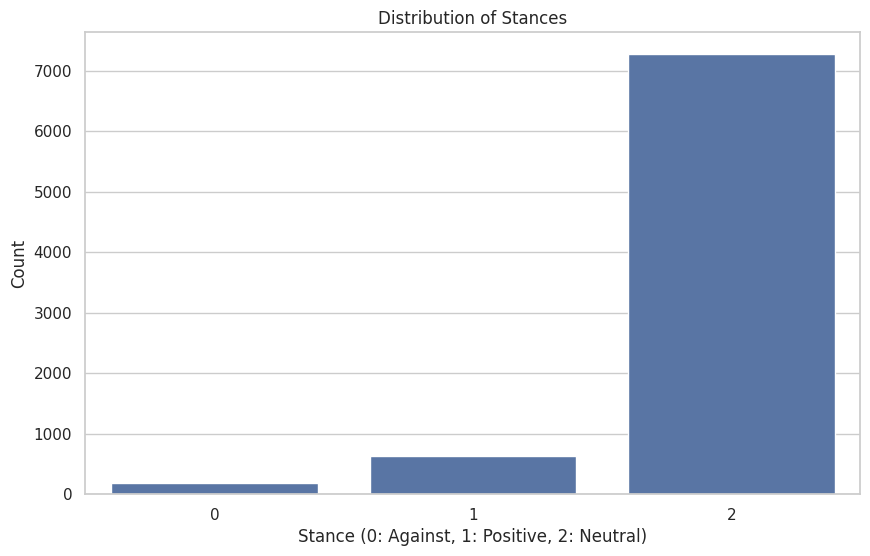

<Figure size 1200x600 with 0 Axes>

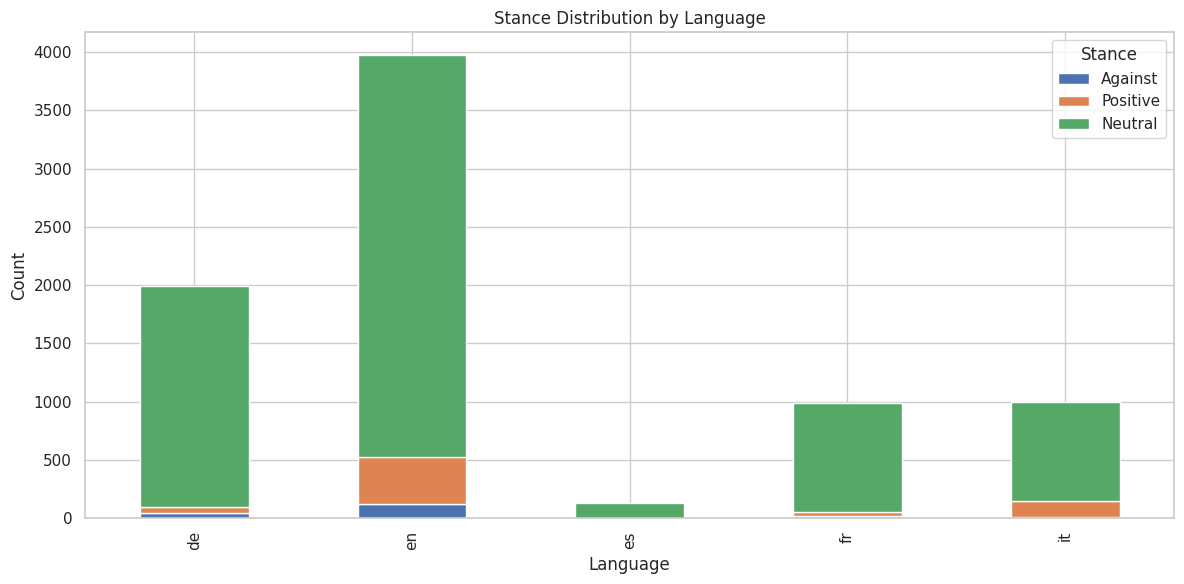

In [42]:
# Visualize stance distribution
plt.figure(figsize=(10, 6))
stance_dist = data['stance'].value_counts()
sns.barplot(x=stance_dist.index, y=stance_dist.values)
plt.title('Distribution of Stances')
plt.xlabel('Stance (0: Against, 1: Positive, 2: Neutral)')
plt.ylabel('Count')
plt.show()

# Visualize stance distribution by language
plt.figure(figsize=(12, 6))
stance_by_lang = pd.crosstab(data['language'], data['stance'])
stance_by_lang.plot(kind='bar', stacked=True)
plt.title('Stance Distribution by Language')
plt.xlabel('Language')
plt.ylabel('Count')
plt.legend(title='Stance', labels=['Against', 'Positive', 'Neutral'])
plt.tight_layout()
plt.show()

In [43]:
# Test cases covering various scenarios
test_cases = {
    'en': [
        "Climate change is real and poses a serious threat",  # Multiple positives
        "Climate change is not real",  # Simple negation
        "Climate change is barely a serious issue",  # Diminished positive
        "This is not a fake crisis",  # Double negative
        "Climate change is slightly exaggerated but still real",  # Mixed with diminisher
        "Climate change is neither a hoax nor exaggerated",  # Multiple negatives with negators
        "There's hardly any evidence that climate change is real",  # Complex diminished
        "This is just alarmist propaganda",  # Multiple negatives with diminisher
        "The threat of climate change is rarely exaggerated"  # Complex mixed case
    ],
    'de': [
        "Der Klimawandel ist eine echte wissenschaftliche Tatsache",  # Multiple positives
        "Der Klimawandel ist nicht real",  # Simple negation
        "Der Klimawandel ist kaum eine ernste Bedrohung",  # Diminished positive
        "Das ist keine Propaganda",  # Simple negative with negator
        "Der Klimawandel ist leicht übertrieben"  # Diminished negative
    ],
    'fr': [
        "Le changement climatique est une réelle menace",  # Multiple positives
        "Ce n'est pas une crise exagérée",  # Complex negation
        "Le changement climatique est à peine une menace",  # Diminished positive
        "Ce n'est pas de la propagande",  # Negated negative
        "Le changement climatique est légèrement exagéré"  # Diminished negative
    ]
}

# Run tests
for lang, texts in test_cases.items():
    print(f"\nTesting {lang.upper()} cases:")
    print("=" * 50)
    for text in texts:
        stance = assign_stance(text, lang)
        print(f"Text: {text}")
        print(f"Stance: {stance}")
        print("-" * 50)


Testing EN cases:
Text: Climate change is real and poses a serious threat
Stance: positive
--------------------------------------------------
Text: Climate change is not real
Stance: negative
--------------------------------------------------
Text: Climate change is barely a serious issue
Stance: negative
--------------------------------------------------
Text: This is not a fake crisis
Stance: positive
--------------------------------------------------
Text: Climate change is slightly exaggerated but still real
Stance: positive
--------------------------------------------------
Text: Climate change is neither a hoax nor exaggerated
Stance: positive
--------------------------------------------------
Text: There's hardly any evidence that climate change is real
Stance: negative
--------------------------------------------------
Text: This is just alarmist propaganda
Stance: negative
--------------------------------------------------
Text: The threat of climate change is rarely exaggera

In [44]:
# Statistical testing for stance distribution
from scipy import stats

contingency_table = pd.crosstab(data['language'], data['stance'])
chi2_results = stats.chi2_contingency(contingency_table)
chi2_stat, p_value, dof, expected = chi2_results

print(f"Chi-square test results:")
print(f"Chi-square statistic: {chi2_stat:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"Degrees of freedom: {dof}")

Chi-square test results:
Chi-square statistic: 218.2345
p-value: 0.0000
Degrees of freedom: 8


In [47]:
# Timestamp extraction
timestamp_str = latest_file.split('_')[-2] + '_' + latest_file.split('_')[-1].split('.')[0]
dt_obj = datetime.datetime.strptime(timestamp_str, '%Y%m%d_%H%M%S')

# Save analysis results and take timestamp from raw data file
analysis_results = {
    'collection_timesstamp': dt_obj.strftime('%Y-%m-%d %H:%M:%S'),
    'total_posts': len(data),
    'language_distribution': data['language'].value_counts().to_dict(),
    'by_subreddit': data['subreddit'].value_counts().to_dict(),
    'stance_distribution': data['stance'].value_counts().to_dict(),
    'stance_by_language': stance_by_lang.to_dict(),
    'language_verification_rate': data['language_verified'].mean()*100,
    'chi2_test': {
        'chi2_statistic': chi2_stat,
        'p_value': p_value,
        'dof': dof
    },
    'mean_stats': {
        'title_length': data['title'].str.len().mean(),
        'body_length': data['body'].str.len().mean(),
        'score': data['score'].mean(),
        'comments': data['num_comments'].mean(),
    },
    'temporal_stats': {
        'earliest_post': data.index.min().strftime('%Y-%m-%d %H:%M:%S'),
        'latest_post': data.index.max().strftime('%Y-%m-%d %H:%M:%S'),
        'peak_day': daily_posts.idxmax().strftime('%Y-%m-%d'),
        'peak_posts': int(daily_posts.max())
    }
}

# Save as JSON with timestamp
import json
results_file = f'../data/processed/preprocessed_stats_{timestamp_str}.json'
os.makedirs(os.path.dirname(results_file), exist_ok=True)
with open(results_file, 'w') as f:
    json.dump(analysis_results, f, indent=4)

## 6. Conclusions and Initial Insights

Based on this exploratory analysis, we can draw some initial conclusions and outline next steps:

### 6.1. Data Quality
- Language verification rate: 97% (high confidence in language labels)
- Total samples processed: 8,081

### 6.2. Data Splits
- Training set: 5,657 samples (70%)
- Validation set: 808 samples (10%)
- Test set: 1,616 samples (20%)

### 6.3. Stance Distribution
- Neutral: 6,609 samples (81.8%)
- Positive: 1,377 samples (17.0%)
- Negative: 94 samples (1.2%)
  
### 6.4. Data Distribution and Language Representation:
   - English dominates the dataset with 3971 posts (49.1%)
   - German has strong representation with 1993 posts (24.7%)
   - Italian and French have similar representation (~990 posts each, ~12%)
   - Spanish is significantly underrepresented with only 130 posts (1.6%)

### 6.5. Content Analysis by Language:
   - English: Broad global perspective, focus on "climate change", action-oriented language
   - German: Strong national focus, emphasis on "Klimakrise" (climate crisis)
   - Spanish: Emphasis on environmental issues and water-related concerns
   - French: Dominated by energy discussions
   - Italian: Focus on "crisi climatica" and climate activism

### 6.6. Engagement Metrics:
   - High variability in post scores (mean ~38, median 10)
   - Comments show similar variability (mean ~14, median 2)
   - Some posts generated extensive discussion (max >1000 comments)

### 6.7. Key Challenges
   - Severe class imbalance in stance classification:
   - Neutral stance dominates the dataset
   - Very few negative stance samples
   - Need for imbalance handling strategies

### 6.8. Cross-Language Insights:
   - While climate change is a universal theme, each language community focuses on different aspects
   - National perspectives are strong in German and French discussions
   - Energy solutions are prominently discussed in French and German posts
   - Environmental pollution and water issues are uniquely emphasized in Spanish content
   - Italian discussions highlight the crisis aspect and climate activism
   - Spanish posts have the highest proportion of neutral stances

### 6.9. Emerging Trends:
   - The recent spike in posting activity coincides with more action-oriented discussions
   - Energy transitions are gaining traction, especially in French discourse
   - There's an increasing focus on local impacts of global climate change

### 6.10. Next Steps:
   - Consider collecting more Spanish content to balance the dataset
   - Refine stance detection algorithm with language-specific keywords
   - Develop more sophisticated content analysis methods
   - Implement cross-validation for stance detection
   - Create visualization dashboard for ongoing monitoring